
Topics: Employment data processing using Pandas, Matplotlib

In [160]:
# Name: Yijin Zhu

A
The data comes from the California Employment Development Department (EDD) and the dataset is the Short-term Occupational Projections, which, based on the EDD website, give a 2-year projection of job outlook, and "_are produced for the State to provide individuals and organizations with an occupational outlook to make informed decisions on individual career and organizational program development_." The dataset is the job growth projection for 2021-2023 and is in the input file `employment.xlsx` from ([data source](https://data.edd.ca.gov/Employment-Projections/Short-Term-Occupational-Employment-Projections/guh4-bakw))

In [2]:
# Import modules here
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# import pyspark modules 

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains

spark = SparkSession.builder.appName('SparkJobScheduing.com').getOrCreate()

df = spark.read.csv("/tmp/resources/data_set1.csv")
# df1, df2 df3. etc for set2, set3 ,set4 processing


1. **Read data from the _employment.xlsx_ file into a DataFrame**.<br>
Then **print the number of rows and columns of the DataFrame and print the first 5 rows**

In [184]:
data = pd.read_excel("employment.xlsx")
print("DataFrame number of rows: ", data.shape[0],
     "\nDataFrame number of columns: ", data.shape[1])
print("First 5 rows:")
data.head()

DataFrame number of rows:  782 
DataFrame number of columns:  18
First 5 rows:


,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Quarter Employment Estimate,Projected Quarter Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,State,California,2021-2023,1,00-0000,"Total, All Occupations",18004000,19296200,1292200,7.2,1601310,2475710,5369220,23.34,48532,NaN,NaN,NaN
1,State,California,2021-2023,2,11-0000,Management Occupations,1261300,1343100,81800,6.5,66360,140150,288310,62.77,130574,NaN,NaN,NaN
2,State,California,2021-2023,3,11-1000,Top Executives,303700,321500,17800,5.9,13140,36800,67740,0.00,0,NaN,NaN,NaN
3,State,California,2021-2023,4,11-1011,Chief Executives,42700,43700,1000,2.3,2360,3490,6850,0.00,0,Bachelor's degree,≥5 years,None
4,State,California,2021-2023,4,11-1021,General and Operations Managers,257700,274500,16800,6.5,10630,33000,60430,57.48,119561,Bachelor's degree,≥5 years,None


2a. It looks like the first 3 columns (Area Type, Area Name, Period) have the same data for all rows.<br>
Write code to **confirm that the first 3 columns have the same data for all rows**.<br>
You should use a loop, don't copy and paste code 3 times.

In [185]:
# 1) access the first data of column i, 
# 2) count the total occurence of this data in column i
# 3) check if the sum of occurence equals to the length of column i

for i in range(3):
    cur_col = data.columns[i]
    first_data = data.at[0, cur_col]
    total_occur = data[cur_col].str.contains(first_data).sum()
    print("Column index: ", i, "\nName: ", cur_col, "\nColumn data: ", first_data, 
          "\nAll rows have the same data: ", total_occur == len(data[cur_col]))
    print()

Column index:  0 
Name:  Area Type 
Column data:  State 
All rows have the same data:  True

Column index:  1 
Name:  Area Name 
Column data:  California 
All rows have the same data:  True

Column index:  2 
Name:  Period 
Column data:  2021-2023 
All rows have the same data:  True



2b. Now that we have confirmation that the dataset is for California and for the years 2021-2023,<br>
**delete the first 3 columns** since they don't add any value to the individual rows.<br>
Then **print the last 4 rows** of the DataFrame to check the updated DataFrame

In [186]:
data.drop(columns=data.columns[:3], inplace=True)
data.tail(4)

,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Quarter Employment Estimate,Projected Quarter Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
778,4,53-7065,Stockers and Order Fillers,273000,290400,17400,6.4,32060,54950,104410,15.56,32371,High school diploma or equivalent,None,Short-term on-the-job training
779,4,53-7081,Refuse and Recyclable Material Collectors,16000,16900,900,5.6,1390,2970,5260,27.45,57085,No formal educational credential,None,Short-term on-the-job training
780,4,53-7121,"Tank Car, Truck, and Ship Loaders",1200,1200,0,0.0,80,210,290,26.02,54120,No formal educational credential,None,Short-term on-the-job training
781,4,53-7199,"Material Moving Workers, All Other",10000,10700,700,7.0,640,1770,3110,15.09,31383,No formal educational credential,None,Short-term on-the-job training


3. Some columns have data that can be derived from other columns, or have more general data:
- SOC Level is more general than the more detailed Standard Occupational Classification (SOC)
- Numeric Change + Exits + Transfers => Total Job Openings
- Projected Quarter Employment Estimates - Base Quarter Employment Estimates => Numeric Change
- Numeric Change is directly related to Percentage Change

Therefore, we can ***delete SOC Level, Numeric Change, Exits, Transfers, Percentage Change, Projected Quarter Employment Estimate***.<br>

In [187]:
data.drop(columns=['SOC Level', 'Numeric Change', 'Exits', 'Transfers', 'Percentage Change', 'Projected Quarter Employment Estimate'], inplace=True)
data.head()

,Standard Occupational Classification (SOC),Occupational Title,Base Quarter Employment Estimate,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,00-0000,"Total, All Occupations",18004000,5369220,23.34,48532,NaN,NaN,NaN
1,11-0000,Management Occupations,1261300,288310,62.77,130574,NaN,NaN,NaN
2,11-1000,Top Executives,303700,67740,0.00,0,NaN,NaN,NaN
3,11-1011,Chief Executives,42700,6850,0.00,0,Bachelor's degree,≥5 years,None
4,11-1021,General and Operations Managers,257700,60430,57.48,119561,Bachelor's degree,≥5 years,None


4. From the previous step, it's obvious that the longer column labels are cumbersome.<br>
***Simplify the column names to: SOC, title, base, openings, hour, annual, education, experience, and training***<br>
Then ***print the first 5 rows*** to verify the updated DataFrame.<br>
You should not have to type in all the original column labels.

In [188]:
data.columns = ['SOC', 'title', 'base', 'openings', 'hour', 'annual', 'education', 'experience', 'training']
data.head()

,SOC,title,base,openings,hour,annual,education,experience,training
0,00-0000,"Total, All Occupations",18004000,5369220,23.34,48532,NaN,NaN,NaN
1,11-0000,Management Occupations,1261300,288310,62.77,130574,NaN,NaN,NaN
2,11-1000,Top Executives,303700,67740,0.00,0,NaN,NaN,NaN
3,11-1011,Chief Executives,42700,6850,0.00,0,Bachelor's degree,≥5 years,None
4,11-1021,General and Operations Managers,257700,60430,57.48,119561,Bachelor's degree,≥5 years,None


5. From the output of the above step, observe that there are NaNs in the DataFrame.
***Print the number of NaNs for each column***<br>
The output should be the column names and the corresponding count of NaNs in the column.

In [167]:
print("NaN count for each column:")
print(data.isna().sum())

NaN count for each column:
SOC             0
title           0
base            0
openings        0
hour            0
annual          0
education     117
experience    117
training      117
dtype: int64


In [ ]:
There are NaNs in the job preparation fields of some occupations. Since we will be investigating the salary and number of job openings, it's okay to have these NaNs in this case.

6. Each entry of the SOC column is a text string made of 2 fields: broad occupation number - detailed occupation number<br>
The broad occupation number describes a general field of employment, such as management, tech, education..., and the detailed occupation is the specific job title within the field.<br>

***Change each SOC value to keep the broad occupation number only***, discarding the dash and the detailed occupation number. Example: 11-1021 will become 11<br>
Then use the Jupyter Notebook print (not Python print() function) to ***print the DataFrame*** to check the updated SOC.<br>

_Ideally you don't need to write a loop for this step, but if you need to, you can write a loop_

In [189]:
import re
data['SOC'] = data['SOC'].str.replace('([-])\w+','', regex=True)
data.head()

,SOC,title,base,openings,hour,annual,education,experience,training
0,00,"Total, All Occupations",18004000,5369220,23.34,48532,NaN,NaN,NaN
1,11,Management Occupations,1261300,288310,62.77,130574,NaN,NaN,NaN
2,11,Top Executives,303700,67740,0.00,0,NaN,NaN,NaN
3,11,Chief Executives,42700,6850,0.00,0,Bachelor's degree,≥5 years,None
4,11,General and Operations Managers,257700,60430,57.48,119561,Bachelor's degree,≥5 years,None


---

Now that we've cleaned up the DataFrame, first we look at the general job trends.<br>

<u>Part A: education level and job titles</u>

7. There are 8 different education levels in the dataset.<br>
***Show the education levels and the number of jobs that require that level of education***<br>
The output should be _sorted by number of jobs_:<br>
`Level A      smallest number
  ...
 Level X      largest number`

In [192]:
print(data.groupby("education").size().sort_values())

education
Some college, no degree                6
Master's degree                       29
Associate's degree                    40
Postsecondary non-degree award        40
Doctoral or professional degree       47
No formal educational credential      88
Bachelor's degree                    151
High school diploma or equivalent    264
dtype: int64


8. ***Show all the job titles for one level of education***<br>
Use your choice of the level of education, and print 2 job titles per line, separated by comma.<br>
Here are the first few lines of output for Bachelor's degree:<br>
`Jobs requiring a Bachelor's degree:
Chief Executives, General and Operations Managers
Legislators, Advertising and Promotions Managers`

_You only need to show 1 level of education for the lab, but feel free to change to other levels to see what jobs are at other levels_

In [170]:

bachelor_jobs = edu_title.get_group("Bachelor's degree")
print("Jobs requiring a Bachelor's degree:")


for i in range(0,bachelor_jobs.shape[0]//2*2, 2):
    print(bachelor_jobs.iloc[i, 0], "and", bachelor_jobs.iloc[i+1, 0])

if bachelor_jobs.shape[0]%2 == 1:
    print(bachelor_jobs.iloc[-1, 0])


Jobs requiring a Bachelor's degree:
Chief Executives and General and Operations Managers
Legislators and Advertising and Promotions Managers
Marketing Managers and Sales Managers
Public Relations and Fundraising Managers* and Administrative Services and Facilities Managers*
Computer and Information Systems Managers and Financial Managers
Industrial Production Managers and Purchasing Managers
Compensation and Benefits Managers and Human Resources Managers
Training and Development Managers and Construction Managers
Education Administrators, Preschool and Childcare Center/Program and Architectural and Engineering Managers
Medical and Health Services Managers and Social and Community Service Managers
Personal Service Managers; Entertainment and Recreation Managers, Except Gambling; and Managers, All Other* and Buyers and Purchasing Agents*
Compliance Officers and Cost Estimators
Human Resources Specialists and Labor Relations Specialists
Logisticians and Management Analysts
Meeting, Conven

<u>Part B: education level and salary</u>

Some of the rows have an hourly pay but no annual pay. We want to calculate the annual pay for these rows.<br>

9a. ***Show the index of the rows with no annual pay but have hourly pay.***<br>
A pay value of 0 means that there is no data.

In [171]:
print("The index of the rows with no annual pay but have hourly pay:")
hour_index = data.index[(data['annual'] == 0) & (data['hour'] != 0)].tolist()
print(*hour_index)


The index of the rows with no annual pay but have hourly pay:
257 261 263 264


9b. Use the index values from step 9a, ***calculate and store the annual pay for those rows*** in the DataFrame<br>
Then ***print the annual pay of those rows***

The annual pay = hourly pay * 40 * 52

In [172]:
data.loc[hour_index,'annual'] = data.loc[hour_index,'hour'] * 40 * 52
print("Updated rows with annual pay: ")
data.loc[hour_index, :]

Updated rows with annual pay: 


,SOC,title,base,openings,hour,annual,education,experience,training
257,27,Actors,20100,8120,23.95,49816.0,"Some college, no degree",None,Long-term on-the-job training
261,27,Dancers,1500,840,18.36,38188.8,No formal educational credential,None,Long-term on-the-job training
263,27,Musicians and Singers,9700,3560,38.93,80974.4,No formal educational credential,None,Long-term on-the-job training
264,27,"Miscellaneous Entertainers and Performers, Spo...",5900,3520,18.33,38126.4,No formal educational credential,None,Short-term on-the-job training


10. Follow the steps below to plot the education vs salary to see if there are correlations<br>

10a. Prepare data to be plotted:
- ***Create a new DataFrame with 2 columns from the curent DataFrame: _annual_ salary and _education_ level***
- ***Remove rows with NaN***
- ***Remove rows with no annual salary***
- ***Change the education level to numeric data***

Then ***print the new DataFrame*** to check your work

In [173]:
sel_col = data[['annual', 'education']]
new_df = sel_col.copy()
new_df = new_df.dropna()
new_df.drop(new_df[new_df['annual'] == 0].index, inplace = True)

#No formal educational credential       1
#High school diploma or equivalent      2
#Some college, no degree                3
#Postsecondary non-degree award         4
#Associate's degree                     5
#Bachelor's degree                      6
#Master's degree                        7
#Doctoral or professional degree        8
new_df.loc[new_df['education'] == "No formal educational credential", 'education'] = 1
new_df.loc[new_df['education'] == "High school diploma or equivalent", 'education'] = 2
new_df.loc[new_df['education'] == "Some college, no degree", 'education'] = 3
new_df.loc[new_df['education'] == "Postsecondary non-degree award", 'education'] = 4
new_df.loc[new_df['education'] == "Associate's degree", 'education'] = 5
new_df.loc[new_df['education'] == "Bachelor's degree", 'education'] = 6
new_df.loc[new_df['education'] == "Master's degree", 'education'] = 7
new_df.loc[new_df['education'] == "Doctoral or professional degree", 'education'] = 8
new_df

,annual,education
4,119561.0,6
5,56483.0,6
7,144551.0,6
8,168186.0,6
9,138392.0,6
...,...,...
777,30374.0,1
778,32371.0,2
779,57085.0,1
780,54120.0,1


10b. Use the <u>proper</u> type of plot to ***plot the correlation between education level and salary***<br>
The plot should have:
- a title
- education levels on one axis and salaries on the other axis
- all labels must be clearly shown: no overlapping labels, font size must be readable

Text(0, 0.5, 'Annual salary')

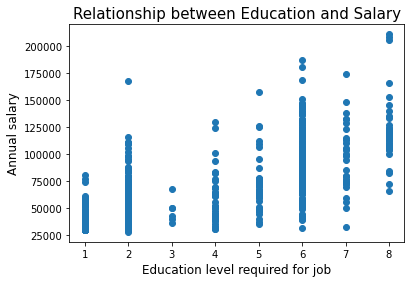

In [174]:
plt.scatter(new_df.education, new_df.annual)
plt.title("Relationship between Education and Salary", fontsize=15)
plt.xlabel("Education level required for job", fontsize=12)
plt.ylabel("Annual salary", fontsize=12)

10c. Data visualization can sometimes tell a story better than analyzing columns of numbers.<br>
***Create a Raw NBConvert cell to describe any pattern you see from the plot***

In [ ]:
For the job requiring education level master degrees and below, there is no huge difference among education levels.
However, the jobs requiring Doctoral or professional degree tend to offer higher salary than any others.

11. The plot of step 10 shows that there are a few jobs which pay really well, above $200,000/yr median salary.<br>
***Print the job titles for jobs that are above 200,000 annual salary.***

In [175]:
data.loc[data.annual > 200000, 'title']

184    Judges, Magistrate Judges, and Magistrates
308          General Internal Medicine Physicians
310                        Pediatricians, General
Name: title, dtype: object

<u>Part C: education and salary of top 2 highest paid fields</u>

12. ***Show the SOC and the median annual salary of each SOC***<br>
The output should be unique SOC numbers and corresponding median salaries, _sorted by median salaries_

In [176]:
print('Median annual salary of each SOC:')
print(data.groupby('SOC')['annual'].median().sort_values(ascending=False))

Median annual salary of each SOC:
SOC
11    119561.0
15    110069.0
17     90377.0
25     84490.0
19     82837.0
13     78035.0
29     75455.5
23     67385.0
27     63176.0
21     54397.0
49     53513.5
33     52550.5
47     52030.0
00     48532.0
43     44229.0
41     38824.0
53     38485.0
51     38159.0
31     37271.5
37     37178.0
39     32946.5
35     30553.5
45     30440.0
Name: annual, dtype: float64


13a. Looking at the output of step 12, you can see the SOC of the top 2 median salaries.<br>
Using these 2 SOC, ***create a DataFrame of all rows that have the 2 SOC***<br>
Then ***print the new DataFrame*** (use Jupyter Notebook print)

In [177]:
top_soc = data.loc[data['SOC'].isin(['11', '15'])]
soc_df = top_soc.copy()
soc_df

,SOC,title,base,openings,hour,annual,education,experience,training
1,11,Management Occupations,1261300,288310,62.77,130574.0,NaN,NaN,NaN
2,11,Top Executives,303700,67740,0.00,0.0,NaN,NaN,NaN
3,11,Chief Executives,42700,6850,0.00,0.0,Bachelor's degree,≥5 years,None
4,11,General and Operations Managers,257700,60430,57.48,119561.0,Bachelor's degree,≥5 years,None
5,11,Legislators,3200,570,0.00,56483.0,Bachelor's degree,<5 years,None
6,11,"Advertising, Marketing, Promotions, Public Rel...",132600,30940,0.00,0.0,NaN,NaN,NaN
7,11,Advertising and Promotions Managers,2300,760,69.50,144551.0,Bachelor's degree,<5 years,None
8,11,Marketing Managers,45100,10960,80.86,168186.0,Bachelor's degree,≥5 years,None
9,11,Sales Managers,75500,16870,66.54,138392.0,Bachelor's degree,<5 years,None
10,11,Public Relations and Fundraising Managers*,9700,2360,62.63,130281.0,Bachelor's degree,≥5 years,None


13b. Working with the new DataFrame, ***remove all rows that have no annual salary and all rows with NaN***

In [178]:
soc_df.dropna(inplace=True)
soc_df.drop(soc_df[soc_df.annual == 0].index, inplace=True)
soc_df

,SOC,title,base,openings,hour,annual,education,experience,training
4,11,General and Operations Managers,257700,60430,57.48,119561.0,Bachelor's degree,≥5 years,None
5,11,Legislators,3200,570,0.00,56483.0,Bachelor's degree,<5 years,None
7,11,Advertising and Promotions Managers,2300,760,69.50,144551.0,Bachelor's degree,<5 years,None
8,11,Marketing Managers,45100,10960,80.86,168186.0,Bachelor's degree,≥5 years,None
9,11,Sales Managers,75500,16870,66.54,138392.0,Bachelor's degree,<5 years,None
10,11,Public Relations and Fundraising Managers*,9700,2360,62.63,130281.0,Bachelor's degree,≥5 years,None
12,11,Administrative Services and Facilities Managers*,42200,9520,51.25,106615.0,Bachelor's degree,<5 years,None
13,11,Computer and Information Systems Managers,84900,18420,89.60,186370.0,Bachelor's degree,≥5 years,None
14,11,Financial Managers,94200,20490,70.91,147484.0,Bachelor's degree,≥5 years,None
15,11,Industrial Production Managers,21000,3860,56.45,117417.0,Bachelor's degree,≥5 years,None


14a. ***Select the 10 rows with the highest annual salary***<br>
Then ***print the title, education, and experience columns of these 10 rows***

In [202]:
top_ten = data.sort_values(by = 'annual', ascending=False).head(10)
top_ten[['title', 'education', 'experience']]

,title,education,experience
184,"Judges, Magistrate Judges, and Magistrates",Doctoral or professional degree,≥5 years
308,General Internal Medicine Physicians,Doctoral or professional degree,None
310,"Pediatricians, General",Doctoral or professional degree,None
13,Computer and Information Systems Managers,Bachelor's degree,≥5 years
27,Architectural and Engineering Managers,Bachelor's degree,≥5 years
303,Nurse Midwives,Master's degree,None
8,Marketing Managers,Bachelor's degree,≥5 years
360,First-Line Supervisors of Police and Detectives,High school diploma or equivalent,<5 years
181,Lawyers,Doctoral or professional degree,None
746,Air Traffic Controllers,Associate's degree,None


14b. What do you observe about title, education level, and experience of these jobs?<br>
***Create a Raw NBConvert cell for your answer***

In [ ]:
What I observe from the top ten jobs with the highest annual salary
Title: many of the highest-earning jobs are medical, social justice and technology related.
Education level: four out of these ten jobs require Doctoral or professional degree; eight out of ten require Bachelor's degree or above.
Experience: half of the top ten jobs do not require experience.

15. Now we find the jobs with the most expected job openings in 2021-2023.<br>
***Select the 10 rows with the highest job openings***<br>
Then ***print the title, job openings, annual salary, education, and experience columns of these 10 rows***

In [180]:
top_opening = data.sort_values(by = 'openings', ascending=False).head(11)
top_opening[['title', 'openings', 'annual', 'education', 'experience']][1:]

,title,openings,annual,education,experience
379,Food Preparation and Serving Related Occupations,800360,30973.0,NaN,NaN
475,Office and Administrative Support Occupations,530780,44956.0,NaN,NaN
739,Transportation and Material Moving Occupations,500210,36149.0,NaN,NaN
448,Sales and Related Occupations,489480,37577.0,NaN,NaN
391,Food and Beverage Serving Workers,427680,0.0,NaN,NaN
337,Healthcare Support Occupations,331220,32102.0,NaN,NaN
769,Material Moving Workers,326860,0.0,NaN,NaN
452,Retail Sales Workers,303410,0.0,NaN,NaN
189,"Education, Training, and Library Occupations",301060,61187.0,NaN,NaN
1,Management Occupations,288310,130574.0,NaN,NaN


16. Now we look at jobs in the tech sector, which has SOC 15.<br>
***Create a DataFrame with rows that have SOC 15***, then ***print the DataFrame***

In [205]:
soc15 = soc_df.loc[data['SOC']=='15']
soc15_df = soc15.copy()
soc15_df

,SOC,title,base,openings,hour,annual,education,experience,training
66,15,Computer Systems Analysts,65600,12540,55.05,114517.0,Bachelor's degree,None,None
67,15,Information Security Analysts,10600,2690,59.61,123975.0,Bachelor's degree,<5 years,None
68,15,Computer and Information Research Scientists,7800,2020,70.96,147605.0,Master's degree,None,None
69,15,Computer Network Support Specialists,15700,3220,34.93,72655.0,Associate's degree,None,None
70,15,Computer User Support Specialists,77300,15480,32.52,67625.0,"Some college, no degree",None,None
71,15,Computer Network Architects,20800,3630,65.77,136800.0,Bachelor's degree,≥5 years,None
72,15,Network and Computer Systems Administrators,31900,5790,48.66,101203.0,Bachelor's degree,None,None
73,15,Database Administrators and Architects*,19000,3810,52.91,110069.0,Bachelor's degree,None,None
74,15,Computer Programmers,22800,3420,51.15,106375.0,Bachelor's degree,None,None
75,15,Software Developers and Software Quality Assur...,311600,72040,66.68,138688.0,Bachelor's degree,None,None


17. Create a plot with 2 subplots (use the <u>appropriate</u> type of plots): 
- Subplot 1: ***Plot the job title and the annual salary of each job***
- Subplot 2: ***Plot the job title and the job openings of each job***

The 2 subplots are lined up top and bottom (vertically)<br>
The salary and the job openings _must be sorted_ in the subplots<br>
The job titles are long, make sure you use a font size that's readable (and choosing the appropriate way to plot will make the job titles more readable)<br>
Adjust the size of the plot and the distance between the 2 subplots so there's no overlap

_Note that you need to create 1 plot with 2 subplots. Don't create 2 different plots_

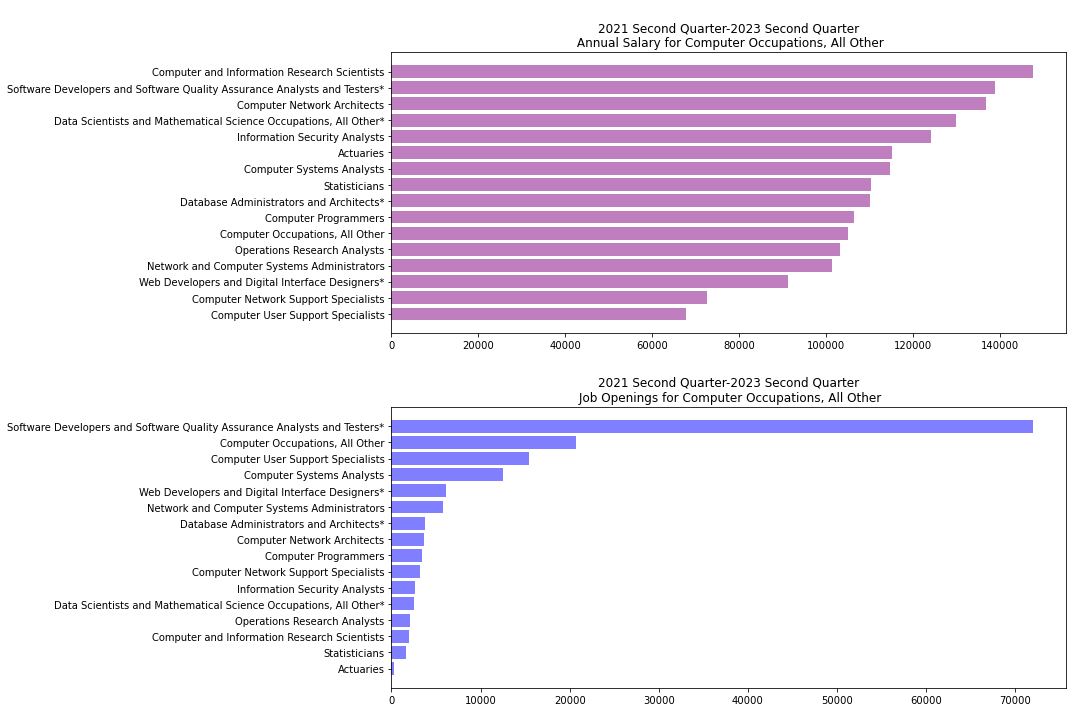

In [206]:
sort_salary = soc15_df.sort_values(by = 'annual')
sort_opening = soc15_df.sort_values(by = 'openings')
f = plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.barh(sort_salary.title, sort_salary.annual, color = 'purple', alpha=0.5)
plt.title("\n2021 Second Quarter-2023 Second Quarter\n Annual Salary for Computer Occupations, All Other")

plt.subplot(2,1,2)
plt.barh(sort_opening.title, sort_opening.openings, color = 'blue', alpha=0.5)
plt.title("\n2021 Second Quarter-2023 Second Quarter\n Job Openings for Computer Occupations, All Other")
plt.tight_layout()


Hopefully the analysis work you've done shows that you're already in or heading towards a promising career.

In [ ]:
covid = pd.read_csv("covid19cases_test.csv")

#covid.drop(columns = ['area_type', 'deaths', 'cumulative_deaths', 'reported_deaths', 'cumulative_reported_deaths', 'reported_tests'])
date = covid.groupby('date').sum()
case = date.loc[:,'cases']

x = pd.to_datetime(case.index.values).tolist()
y = case.values.tolist()

ax = plt.subplot(111)
ax.bar(x, y, width=50)
ax.xaxis_date()
case.rolling(window=7).mean()
ax.set_ylabel('7 Day Average Number of New Covid-19 Cases', fontsize=10)
ax.set_title("Distribution of CA COVID-19 New Cases\n Jan 2020 - Jul 2022")
plt.xticks(rotation=30)
plt.show()